In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
def download_link(url):
  '''Method reformates the share link from Google Drive into fetchable form'''
  return 'https://drive.google.com/uc?id=' + url.split('/')[-2]

In [3]:
# Cycling data
cycling_data = pd.read_csv(download_link("https://drive.google.com/file/d/15eHai6zkPwOBMq59n8uIjjohuuiaV8DF/view?usp=sharing"))

In [6]:
def clean_data(data):
    '''Removes unnecessary columns, creates datetime index and total cyclists column'''
    data = data.copy()
    data["date_time"] = pd.to_datetime(data["DATUM_A_CAS"], errors="coerce")
    data["cyclists_total"] = data["POCET_DO"] + data["POCET_Z"]
    data = data.rename(columns={"NAZOV": "name", "POCET_DO": "direction_to", "POCET_Z": "direction_from"})


    columns = ["name", "date_time", "cyclists_total", "direction_to", "direction_from"]
    data = data[columns].sort_values(by="date_time")
    return data

In [7]:
data = clean_data(cycling_data)

In [ ]:
data_with_corona = data
data_after_corona = data[data["date_time"] >= "2022-01-01"]

In [9]:
def create_features(df):
    """Create time series features based on time index."""
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    # cyclic notation for day of the week
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek']/7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek']/7)
    #is weekend
    df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
    # spring/fall/summer/winter
    df['is_spring'] = df['month'].isin([3,4,5]).astype(int)
    df['is_summer'] = df['month'].isin([6,7,8]).astype(int)
    df['is_fall'] = df['month'].isin([9,10,11]).astype(int)
    df['is_winter'] = df['month'].isin([12,1,2]).astype(int)

    return df

In [10]:
data_with_features = create_features(data_after_corona.set_index('date_time'))

In [15]:
FEATURES_1 = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'is_weekend', 'is_spring', 'is_summer', 'is_fall', 'is_winter']
FEATURES_2 = ['hour', 'dayofweek_sin','dayofweek_cos', 'quarter', 'month', 'year', 'dayofyear', 'is_weekend', 'is_spring', 'is_summer', 'is_fall', 'is_winter']
TARGET_TOTAL = 'cyclists_total'
TARGET_TO = 'direction_to'
TARGET_FROM = 'direction_from'

In [16]:
routes = list(data["name"].unique())

In [19]:
results = []

In [ ]:
for route in routes:
    print(f"=== ROUTE: {route} ===")
    for n_estimators in [500, 1000, 2000, 5000]:
        for learning_rate in [0.01, 0.05, 0.1, 0.9]:
            
            route_data = data_with_features[data_with_features["name"] == route].copy()

            DATA = route_data

            TRAIN = DATA[:int(0.6*len(DATA))]
            VALIDATION = DATA[int(0.6*len(DATA)):int(0.8*len(DATA))]

            X_train = TRAIN[FEATURES_1]
            y_train = TRAIN[TARGET_TOTAL]

            X_val = VALIDATION[FEATURES_1]
            y_val = VALIDATION[TARGET_TOTAL]
            mean_val = y_val.mean()


            MODEL = xgb.XGBRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                early_stopping_rounds=100,
                eval_metric="mae"
            )

            MODEL.fit(X_train, y_train,
                eval_set = [(X_train, y_train), (X_val, y_val)],
                verbose=False)
            
            best_mae = MODEL.best_score
            
            #evals_result = MODEL.evals_result()
            #best_val_score = min(evals_result['validation_1']['mae'])
            rel_mae = (best_mae / mean_val) * 100 if mean_val > 0 else 0
        
        
            results.append({
                'route': route,
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'model': MODEL,
                'best_val_score': MODEL.best_score
            })

            print(f"Done: {route} | Najlepšie Rel. MAE v tomto kole: {rel_mae:.2f}%")



[0]	validation_0-mae:20.23904	validation_1-mae:17.05009
[1]	validation_0-mae:20.09298	validation_1-mae:16.90283
[2]	validation_0-mae:19.94878	validation_1-mae:16.75785
[3]	validation_0-mae:19.80732	validation_1-mae:16.61568
[4]	validation_0-mae:19.66765	validation_1-mae:16.47639
[5]	validation_0-mae:19.53009	validation_1-mae:16.33828
[6]	validation_0-mae:19.39411	validation_1-mae:16.20322
[7]	validation_0-mae:19.26126	validation_1-mae:16.07003
[8]	validation_0-mae:19.13008	validation_1-mae:15.93972
[9]	validation_0-mae:19.00081	validation_1-mae:15.81034
[10]	validation_0-mae:18.87324	validation_1-mae:15.68274
[11]	validation_0-mae:18.74871	validation_1-mae:15.55939
[12]	validation_0-mae:18.62553	validation_1-mae:15.43752
[13]	validation_0-mae:18.50405	validation_1-mae:15.31741
[14]	validation_0-mae:18.38148	validation_1-mae:15.19827
[15]	validation_0-mae:18.26121	validation_1-mae:15.08089
[16]	validation_0-mae:18.14308	validation_1-mae:14.96548
[17]	validation_0-mae:18.02669	validation

In [23]:
results_df = pd.DataFrame(results)

best_results_per_route = results_df.loc[results_df.groupby('route')['best_val_score'].idxmin()]


for _, row in best_results_per_route.iterrows():
    print(f"Route: {row['route']}, Best MAE: {row['best_val_score']:.4f}, n_estimators: {row['n_estimators']}, learning_rate: {row['learning_rate']}")
    best_model_for_route = row['model']

Route: #1 - Starý Most, Best MAE: 8.5900, n_estimators: 1000, learning_rate: 0.01
Route: #10 - Dunajská, Best MAE: 4.0397, n_estimators: 500, learning_rate: 0.1
Route: #11 - Most Apollo, Best MAE: 14.2666, n_estimators: 500, learning_rate: 0.1
Route: #12 - Železná studnička, Best MAE: 10.6791, n_estimators: 500, learning_rate: 0.01
Route: #13 - Vajanského 1, Best MAE: 7.2011, n_estimators: 500, learning_rate: 0.05
Route: #14 - Vajanského 2, Best MAE: 14.3979, n_estimators: 500, learning_rate: 0.05
Route: #15 - Incheba Einsteinova, Best MAE: 11.6678, n_estimators: 500, learning_rate: 0.1
Route: #16 - Trenčianska, Best MAE: 11.3539, n_estimators: 500, learning_rate: 0.1
Route: #17 - Dunajská/Lazaretská, Best MAE: 10.9066, n_estimators: 500, learning_rate: 0.9
Route: #2 - Starý most 2, Best MAE: 7.4183, n_estimators: 500, learning_rate: 0.05
Route: #3 - River Park, Best MAE: 13.6120, n_estimators: 500, learning_rate: 0.05
Route: #4 - Dolnozemská, Best MAE: 26.2033, n_estimators: 500, lear

### Testing

In [26]:
test_results = {}

In [31]:
for route in routes:

    route_data = data_with_features[data_with_features["name"] == route].copy()

    DATA = route_data

    TRAIN = DATA[:int(0.6*len(DATA))]
    VALIDATION = DATA[int(0.6*len(DATA)):int(0.8*len(DATA))]
    TEST = DATA[int(0.8*len(DATA)):int(len(DATA))]


    X_train = TRAIN[FEATURES_1]
    y_train = TRAIN[TARGET_TOTAL]

    X_val = VALIDATION[FEATURES_1]
    y_val = VALIDATION[TARGET_TOTAL]

    X_train_val = pd.concat([X_train, X_val])
    y_train_val = pd.concat([y_train, y_val])

    X_test = TEST[FEATURES_1]
    y_test = TEST[TARGET_TOTAL]

    best_params = best_results_per_route[best_results_per_route['route'] == route].iloc[0]
    n_estimators = best_params['n_estimators']
    learning_rate = best_params['learning_rate']

    MODEL = xgb.XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        eval_metric="mae"
    )

    MODEL.fit(X_train_val, y_train_val, verbose=False)

    y_pred = MODEL.predict(X_test)

    mae = np.mean(np.abs(y_test - y_pred))
    mean_test = y_test.mean()
    rel_mae_test = (mae / mean_test) * 100 if mean_test > 0 else 0

    test_results[route] = {
        'mse': mse,
        'mae': mae,
        'rel_mae': rel_mae_test,
        'y_test': y_test.values,
        'y_pred': y_pred
    }

    print(f"Route: {route}, Test MSE: {mse:.4f}, Test MAE: {mae:.4f}, Rel MAE: {rel_mae_test:.4f}")

    

Route: Cyklomost Slobody, Test MSE: 309.0866, Test MAE: 11.5981, Rel MAE: 80.4180
Route: Hradza Berg, Test MSE: 309.0866, Test MAE: 9.6071, Rel MAE: 71.4393
Route: Viedenska, Test MSE: 309.0866, Test MAE: 14.0389, Rel MAE: 48.2389
Route: Devinska Nova Ves, Test MSE: 309.0866, Test MAE: 5.2510, Rel MAE: 72.6583
Route: #1 - Starý Most, Test MSE: 309.0866, Test MAE: 11.7547, Rel MAE: 41.0373
Route: #3 - River Park, Test MSE: 309.0866, Test MAE: 25.3906, Rel MAE: 55.0633
Route: #4 - Dolnozemská, Test MSE: 309.0866, Test MAE: 37.6278, Rel MAE: 48.6573
Route: #5 - Devínska cesta, Test MSE: 309.0866, Test MAE: 8.3641, Rel MAE: 177.0795
Route: #8 - Most SNP, Test MSE: 309.0866, Test MAE: 18.7004, Rel MAE: 86.5300
Route: #9 - Páričkova, Test MSE: 309.0866, Test MAE: 9.8324, Rel MAE: 40.1468
Route: #6 - Vajnorská, Test MSE: 309.0866, Test MAE: 5.3471, Rel MAE: 72.7091
Route: #10 - Dunajská, Test MSE: 309.0866, Test MAE: 9.9236, Rel MAE: 56.2380
Route: #12 - Železná studnička, Test MSE: 309.0866,

In [28]:
test_results_df = pd.DataFrame(test_results)

In [29]:
test_results_df.to_csv("XGBoost_val_results")
results_df.to_csv("XGBoost_test_results")

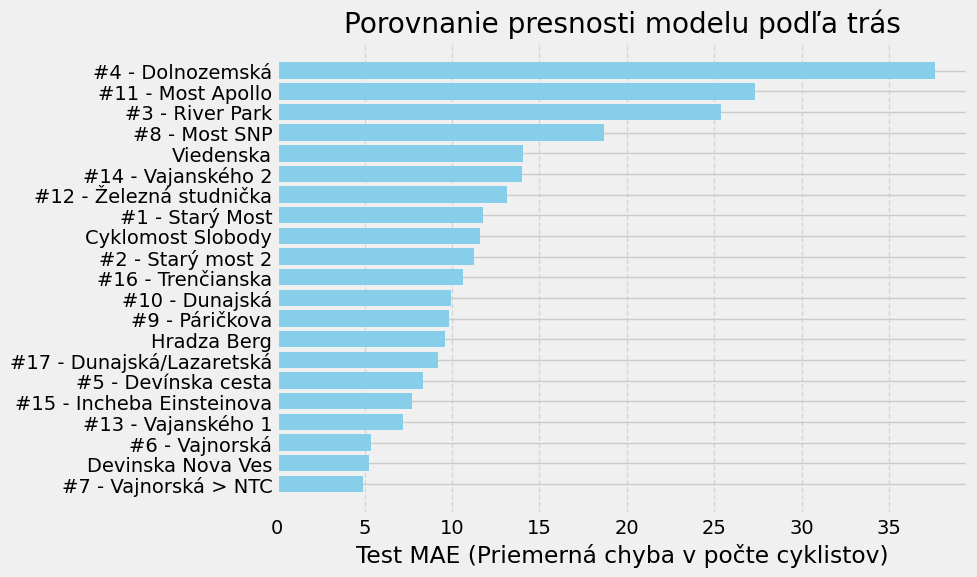

In [30]:
df_res = pd.DataFrame.from_dict(test_results, orient='index').reset_index()
df_res.columns = ['route', 'mse', 'mae', 'model']
df_res = df_res.sort_values('mae')

# Vizualizácia MAE
plt.figure(figsize=(10, 6))
plt.barh(df_res['route'], df_res['mae'], color='skyblue')
plt.xlabel('Test MAE (Priemerná chyba v počte cyklistov)')
plt.title('Porovnanie presnosti modelu podľa trás')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()